In [2]:
# CPLEX sur python
pip install docplex

In [3]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline

# Calcul des distances

In [4]:
import folium

In [88]:
def feuille_excel(f) :
    df = pd.read_excel("distances.xlsx", sheet_name=f, index_col=0)
    return(df)
df = feuille_excel("Feuil5")

In [89]:
# création de tuples représentant notre location
location = []
for i in range (len(df)) :
    location.append((df.iloc[i,0], df.iloc[i,1]))
# centrer la carte à Casablanca
casablanca = (33.5731104, -7.5898434)
#print(location)

In [90]:
# création d'une carte Folium centrée à la ville au-dessus
m = folium.Map(location=casablanca, zoom_start=4, width=800, height=400)

In [91]:
# ajout des markers aux locations
for i in range(len(location)) :
    folium.Marker(location[i], popup="Point de vente").add_to(m)
# affichage de la carte dans Jupyter notebooks
#m

In [92]:
# Calcul de distance entre les points de vente
from geopy.distance import distance
    
km=np.zeros((len(location),len(location)))  
for i in range(len(location)):
    for j in range(len(location)):
        km[i,j]= distance(location[i], location[j]).km
print(km)
print(km.shape)
            

[[0.         1.03404704 1.34132115 0.53390358 1.24406376 1.942834
  2.43619059 1.19349432 0.49701572 1.32745081 1.18191203 2.65464104
  1.36853299 1.60171019 4.17217405 2.46707317 1.06451552 0.28007539
  0.72233702 2.52681321 1.20183866 1.08829062]
 [1.03404704 0.         2.14779378 1.48814315 2.20930961 2.8826071
  3.45602033 2.22334424 1.27265427 2.16676598 2.15644121 3.49731373
  2.22648355 2.28115413 5.08987196 3.3758344  1.69341631 0.77412788
  1.75288923 3.36899763 2.05822927 2.09693529]
 [1.34132115 2.14779378 0.         0.82723251 1.6529262  0.83427945
  1.6445503  1.2372742  0.89902323 0.08907728 0.55448894 1.35057759
  2.00807511 0.37750387 2.95312176 1.25092694 0.5226893  1.58522667
  0.95893445 1.22200344 1.90923069 0.73669188]
 [0.53390358 1.48814315 0.82723251 0.         1.14782579 1.41684634
  1.97789928 0.90674634 0.30357945 0.80313748 0.66943718 2.12144203
  1.41088373 1.12920461 3.64462909 1.93579818 0.68656809 0.80276581
  0.38598662 1.99381941 1.27139346 0.62050261]

# Affichage de high frequency stores 

In [93]:
def feuille_excel(f) :
    df = pd.read_excel("clusters_2.xlsx", sheet_name=f, index_col=0)
    return(df)

In [94]:
df=feuille_excel("Feuille_5")
print(len(df))

22


In [95]:
n=df.client[1:].tolist()

No handles with labels found to put in legend.


(Text(0.5, 0, 'Latitude'),
 Text(0, 0.5, 'Longitude'),
 Text(0.5, 1.0, 'Tours'),
 <matplotlib.legend.Legend at 0x2295daa8790>)

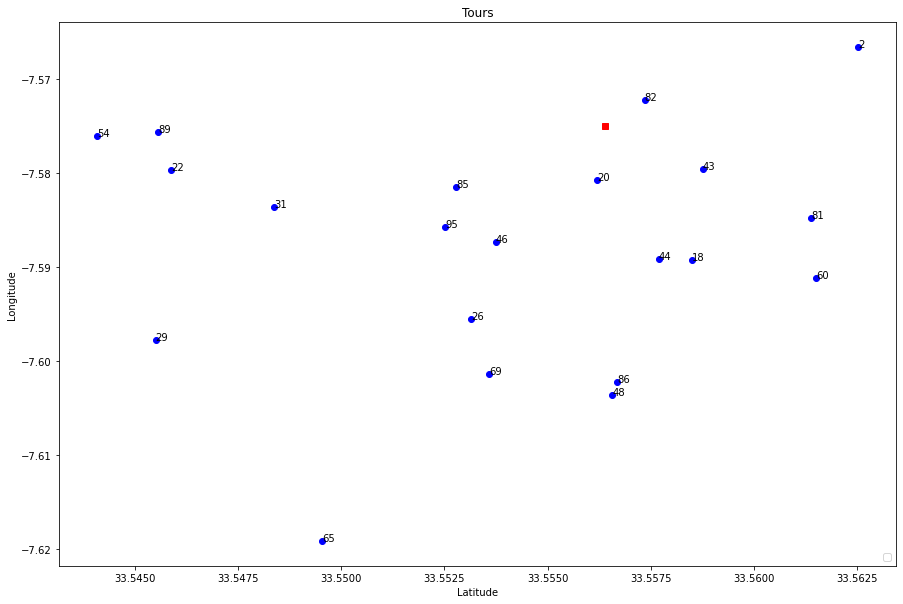

In [96]:
#fig, ax = plt.subplots()
plt.figure(figsize=(15,10))
plt.scatter(df.Latitude[0:], df.Longitude[0:], c='b')
plt.plot(df.Latitude[0], df.Longitude[0], c='r', marker='s')
for i in n:
    plt.annotate(int(i), (df.Latitude[i], df.Longitude[i]))
plt.xlabel("Latitude"), plt.ylabel("Longitude"), plt.title("Tours"), plt.legend(loc = 4)
#plt.show()

In [97]:
rnd = np.random
rnd.seed(0)

# Résolution de Heterogeneous capacitated vehicle routing problem (HCVRP)

In [98]:
from docplex.mp.model import Model

In [99]:
# Nombre de Nodes
nbVilles = 22
# Index: Range ville
villes=range(nbVilles)
# Nombre de vehicules
nbVehicles=1
vehicles=range(nbVehicles)
# Cout entre node i et node j.
cij=km
#print(cij)
# demande de chaque client i.
di=np.array([8,8,7,15,7,6,7,8,6,5,6,8,12,9,6,9,10,8,9,10,12,12])
# capacité de chaque véhicule 
qk = np.array([250])

In [100]:
# Définition du model
model=Model('CVRP')

In [101]:
# Variable xij
x=model.binary_var_cube(keys1=villes,keys2=villes,keys3=vehicles,name='x')
# Varible ui
u=model.integer_var_matrix(keys1=villes, keys2=vehicles,lb=0, ub=nbVilles,name='u')

In [102]:
# Fonction Objectif
model.minimize(model.sum(cij[i,j] * x[i,j,k] for i in villes for j in villes for k in vehicles))

In [103]:
# Contraintes:

# #### Contrainte 1:
for j in villes:
    if j > 0 :
        model.add_constraint(model.sum( x[i , j , k] for i in villes for k in vehicles )==1 , ctname="c1")

# #### Contrainte 2:
for j in villes:
    for k in vehicles:
        model.add_constraint(model.sum(x[i , j , k] for i in villes )==model.sum(x[j , i , k] for i in villes) , ctname="c2")


# #### Contrainte 3:
for k in vehicles:
    model.add_constraint(model.sum(x[0 , j , k] for j in villes if j>0)==1, ctname="c3")


# #### Contrainte 4:
for k in vehicles:
    model.add_constraint( model.sum(di[j] * x[i , j,k] for i in villes for j in villes if j>0)<=qk[k], ctname="c4")


# #### Contrainte 5:
for i in villes:
    for j in villes:
        if j > 0:
            for k in vehicles:
                model.add_constraint(u[i,k]-u[j,k]+(nbVilles -nbVehicles)* x[i,j , k]<=(nbVilles - nbVehicles -1), ctname="c5")

In [104]:
# Solve
solution = model.solve(log_output=True)

-- cannot find parameters matching version: 22.1.0.0, using: 20.1.0.0
CPLEX Error  1013: Bad parameter number to CPLEX parameter routine.
CPLEX Error  1013: Bad parameter number to CPLEX parameter routine.
CPLEX Error  1013: Bad parameter number to CPLEX parameter routine.
Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 21 rows and 23 columns.
MIP Presolve modified 945 coefficients.
Reduced MIP has 485 rows, 483 columns, and 2226 nonzeros.
Reduced MIP has 462 binaries, 21 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.43 ticks)
Probing time = 0.02 sec. (2.02 ticks)
Cover probing fixed 0 vars, tightened 21 bounds.
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 21 rows and 0 columns.
Reduced MIP has 464 rows, 483 columns, and 2184 nonzeros.
Reduced MIP has 462 binaries, 21 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.80 

In [105]:
solution.display()

solution for: CVRP
objective: 14.360
x_0_17_0 = 1
x_1_8_0 = 1
x_2_9_0 = 1
x_3_0_0 = 1
x_4_12_0 = 1
x_5_15_0 = 1
x_6_10_0 = 1
x_7_4_0 = 1
x_8_16_0 = 1
x_9_5_0 = 1
x_10_21_0 = 1
x_11_14_0 = 1
x_12_20_0 = 1
x_13_2_0 = 1
x_14_6_0 = 1
x_15_19_0 = 1
x_16_13_0 = 1
x_17_1_0 = 1
x_18_3_0 = 1
x_19_11_0 = 1
x_20_18_0 = 1
x_21_7_0 = 1
u_1_0 = 2
u_2_0 = 6
u_3_0 = 21
u_4_0 = 17
u_5_0 = 8
u_6_0 = 13
u_7_0 = 16
u_8_0 = 3
u_9_0 = 7
u_10_0 = 14
u_11_0 = 11
u_12_0 = 18
u_13_0 = 5
u_14_0 = 12
u_15_0 = 9
u_16_0 = 4
u_17_0 = 1
u_18_0 = 20
u_19_0 = 10
u_20_0 = 19
u_21_0 = 15


In [72]:
solution.solve_status

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [73]:
active_arcs=[]
for k in vehicles :
    for i in range(len(df)) :
        for j in range(len(df)) :
            if (i!=j and x[i,j,k].solution_value > 0.9) :
                active_arcs.append((i,j))
active_arcs

[(0, 13),
 (1, 6),
 (2, 1),
 (3, 9),
 (4, 0),
 (5, 8),
 (6, 17),
 (7, 18),
 (8, 3),
 (9, 19),
 (10, 20),
 (11, 16),
 (12, 15),
 (13, 5),
 (14, 12),
 (15, 21),
 (16, 14),
 (17, 7),
 (18, 11),
 (19, 2),
 (20, 4),
 (21, 10)]

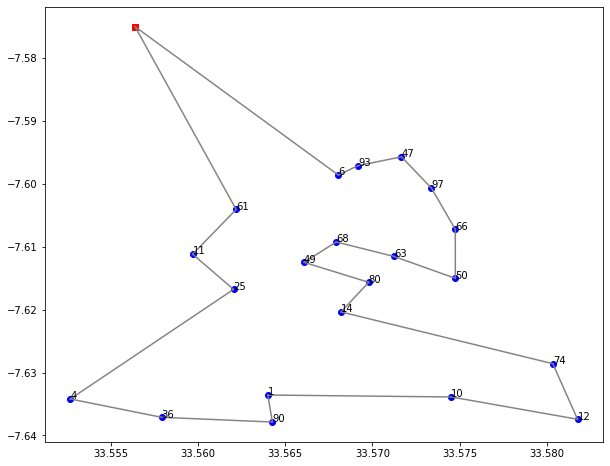

In [74]:
plt.figure(figsize=(10,8))
plt.scatter(df.Latitude[0:], df.Longitude[0:], c='b')
plt.plot(df.Latitude[0], df.Longitude[0], c='r', marker='s',label="dépôt")
for i in n:
    plt.annotate(int(i), (df.Latitude[i], df.Longitude[i]))
for i, j in active_arcs:
    plt.plot([df[['Latitude']].iloc[i], df[['Latitude']].iloc[j]], [df[['Longitude']].iloc[i], df[['Longitude']].iloc[j]], c='grey', alpha=10)

In [75]:
# Séquence de visites
a=0;

rt=np.zeros((nbVehicles))
i=0
for v in vehicles :
    for s in villes :
        if (solution.get_value(x[0, s, v])>0) :
            rt[v] = int(s);
print(rt)
for v in vehicles :
    k = rt[v]
    breaker=False
    a = int(k)
    print("v:"+str(a));
    for b in villes :
        for c in villes :
            if solution.get_value(x[a, c, v])>0 :
                print("(ordre "+str(u[a, v])+": "+ str(round(solution.get_value(u[a, v]))) + " noeud: x_"+str(a)+")", end="=>")
                a=c
                if (a==0):
                    b=nbVilles
                    print("")
                    breaker=True
                    break
        if breaker :
            break          

[13.]
v:13
(ordre u_13_0: 1 noeud: x_13)=>(ordre u_5_0: 2 noeud: x_5)=>(ordre u_8_0: 3 noeud: x_8)=>(ordre u_3_0: 4 noeud: x_3)=>(ordre u_9_0: 5 noeud: x_9)=>(ordre u_19_0: 6 noeud: x_19)=>(ordre u_2_0: 7 noeud: x_2)=>(ordre u_1_0: 8 noeud: x_1)=>(ordre u_6_0: 9 noeud: x_6)=>(ordre u_17_0: 10 noeud: x_17)=>(ordre u_7_0: 11 noeud: x_7)=>(ordre u_18_0: 12 noeud: x_18)=>(ordre u_11_0: 13 noeud: x_11)=>(ordre u_16_0: 14 noeud: x_16)=>(ordre u_14_0: 15 noeud: x_14)=>(ordre u_12_0: 16 noeud: x_12)=>(ordre u_15_0: 17 noeud: x_15)=>(ordre u_21_0: 18 noeud: x_21)=>(ordre u_10_0: 19 noeud: x_10)=>(ordre u_20_0: 20 noeud: x_20)=>(ordre u_4_0: 21 noeud: x_4)=>
